## Table of contents
1. [Project Definition & Business Objectives](#intro)
   - [1.1 What Is the Business Problem?](#problem)
   - [1.2 What is the Objective of the project?](#objective)
2. [Technical Specifications & Solution Overview](#tech)
   - [2.1 Tools](#tool)
   - [2.2 Datasets](#data)
   - [2.3 Solution Overview](#solution)
3. [Exploratary Analysis](#eda)
4. [Data Engineering](#prep)
   - [4.1 Data Cleaning](#clean)
   - [4.2 Data preparation](#dprep)
   - [4.3 Feature Engineering](#feature)
5. [Predictive Model](#model)
   - [5.1 Parameter Tuning](#param)
   - [5.2 Training Strategy](#strategy)
6. [Appendix](#summary)

## I.	Project Definition & Business Objectives <a name="intro"></a>

### 1.1 What Is the Business Problem? <a name="problem"></a>

Sales forecasting is essential for running a successful business, especially for businesses in the retail industry. Accurately predicting unit product sales at different points of time is crucial for retail stores in meeting consumer demand and managing product inventory; however,  it can be a complex problem with many factors such as products coming from various of categories, different store location may be running different promotion and special events, change of pricing, etc. This forecasting problem is further complicated by its hierarchical time series sales data.

Walmart Inc. is an American multinational retail corporation headquartered in the United States. It operates a chain of retail stores and e-commerce stores in 24 countries. For this business problem, we are making point forecasts of unit sales of ten Walmart stores’ retail goods across three states California, Texas, and Wisconsin for two 28 day time periods.


### 1.2 What is the Objective of the project?<a name="objective"></a>

In this project, our goal is to predict the unit sales of 3049 items from seven departments and three product categories for ten stores across three states. The accuracy of our predictions will be measured automatically by the Kaggle platform by comparing our predictions to the actual sales of the two 28 day time periods in their datasets.

From the business perspectives, successfully predicting the daily sales would allow the organization to implement this algorithm for all stores across the globe to improve their operational efficiency in inventory planning and better serve their customers. In addition, knowing actual demand of products also reveals opportunities in product sourcing and making better decisions in marketing strategy.


## II.	Technical Specifications & Solution Overview <a name="tech"></a>

### 2.1 Tools  <a name="tool"></a>

- Pandas
- Numpy
- Sklearn
- Lightgbm
- Scipy
- Pickle

In [3]:
# Import libaries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import pickle
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### 2.2 Datasets <a name="data"></a>

The datasets we used in this project were provided by the Kaggle competition. There are four main data files, and below are the descriptions of each files:
1.	`calendar.csv` - This file contains information about the dates on which the products are sold.
2.	`sales_train_validation.csv` - This file contains the historical daily unit sales data per product and store from day 1 to day 1919.
3.	`sell_prices.csv` - This file contains information about the price of the products sold per store and date. 
4.	`sales_train_evaluation.csv` - This file contains the same historical daily unit sales data per product and store like the sales_train_validation dataset, but it also contains sales data from day 1920  to day 1941.


In [4]:
# from google.colab import drive
 
# drive.mount('/content/drive')
# %cd '/content/drive/Shared drives/Predictive Analysis- Walmart'

In [ ]:
sales_train_evaluation_ = pd.read_csv('/content/sales_train_evaluation.csv')
calendar_ = pd.read_csv('/content/calendar.csv')
sell_prices_ = pd.read_csv('/content/sell_prices.csv')
STORES_IDS = list(sales_train_evaluation_['store_id'].unique())

### 2.3 Solution Overview <a name="solution"></a>

Our solutions aims to solve this forecasting problem with $Ensembling Model-Boosting$

$LightGBM$ is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages: 
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel, distributed, and GPU learning.
- Capable of handling large-scale data.


## III.	Exploratory Analysis <a name="eda"></a>

**1. Calendar dataset**

In [4]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [5]:
calendar.head(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0


In [6]:
calendar.tail(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


#### 1a.1 Data duration

In [7]:
calendar['year'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016], dtype=int64)

In [8]:
months = calendar.groupby(['year','month']).size().to_frame(name = 'days of the month').reset_index()
months

,year,month,days of the month
0,2011,1,3
1,2011,2,28
2,2011,3,31
3,2011,4,30
4,2011,5,31
...,...,...,...
61,2016,2,29
62,2016,3,31
63,2016,4,30
64,2016,5,31


In [9]:
months.shape

(66, 3)

The data is from 2011-2016 (specifically from 2011-01-29 to 2016-06-19), total of 66 months while first month only have 3 days and last month only have 19 days. Total 1969 days.

#### 1a.2 Event types

In [10]:
Etype1= calendar.groupby(['event_type_1']).size().to_frame(name = 'count').reset_index()

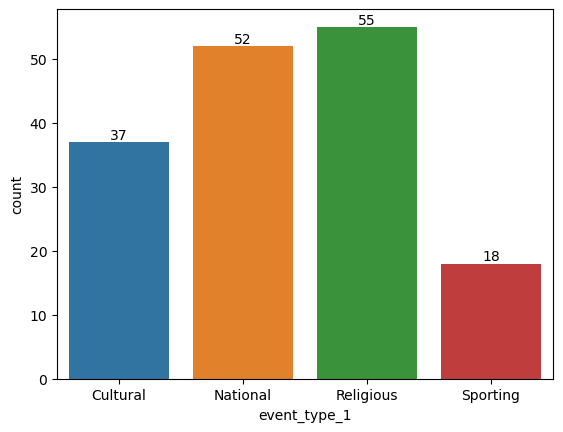

In [11]:
# plot event type 1
e1 = sns.barplot(data=Etype1, x='event_type_1', y="count")

# add label for each type
for i in e1.containers:
    e1.bar_label(i,)

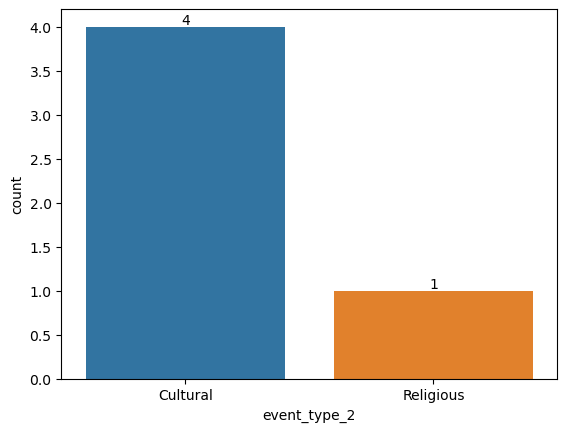

In [12]:
Etype2= calendar.groupby(['event_type_2']).size().to_frame(name = 'count').reset_index()

# plot number of event type 2
e2 = sns.barplot(data=Etype2, x='event_type_2', y="count")

# add label
for i in e2.containers:
    e2.bar_label(i,)

In [13]:
calendar[(calendar['event_type_1'] != 0) & (calendar['event_type_2'] != 0)]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


There are four event type: Culture, National, Religious, and Sporting. There are 5 days, where there are two type of events occur on the same day.

In [14]:
# number of events per type per years
type1 = calendar.groupby(by = ['year','event_type_1'])['event_type_1'].count()
type1

year  event_type_1
2011  Cultural         6
      National         8
      Religious        9
      Sporting         3
2012  Cultural         7
      National        10
      Religious       10
      Sporting         3
2013  Cultural         6
      National        10
      Religious       10
      Sporting         3
2014  Cultural         6
      National        10
      Religious        9
      Sporting         3
2015  Cultural         7
      National        10
      Religious       10
      Sporting         3
2016  Cultural         5
      National         4
      Religious        7
      Sporting         3
Name: event_type_1, dtype: int64

In [15]:
type2 = calendar.groupby(by = ['year','event_type_2'])['event_type_2'].count()
type2

year  event_type_2
2011  Cultural        1
2013  Cultural        1
2014  Cultural        1
      Religious       1
2016  Cultural        1
Name: event_type_2, dtype: int64

#### 1a.3 SNAP per State

Same for all 3 states, so only show one illustration:

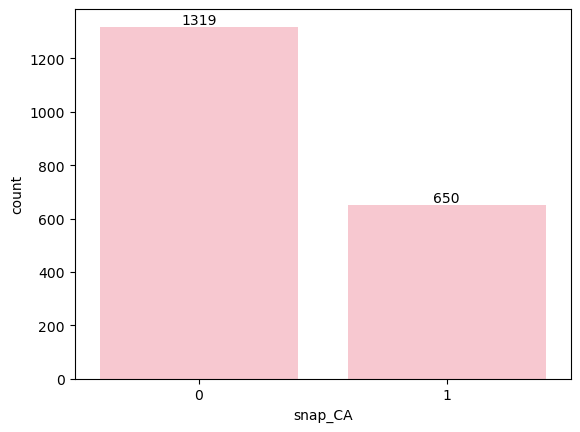

In [16]:
snapCA= calendar.groupby(['snap_CA']).size().to_frame(name = 'count').reset_index()

snapca = sns.barplot(data=snapCA, x='snap_CA', y="count", color = 'pink')
for i in snapca.containers:
    snapca.bar_label(i,)

#### 2. Price dataset

In [19]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [20]:
price.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [21]:
price.store_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [22]:
price['store_id'].nunique()

10

In [23]:
price.item_id.nunique()

3049

There are total 10 stores. 4 in CA, 3 in TX, and 3 in WI. And there are total of 3049 items.

#### 3. sales_train dataset

In [24]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [25]:
sales_train.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [26]:
department = sales_train.dept_id.unique()
department

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

There are 3 item categories, and 7 departments. With 2 hobbies department, 2 household departments, and 3 foods departments.
The dataset also records item daily sales from day1 to day 1913.

## IIII.  Data Engineering <a name="prep"></a>

### 3a. Data Cleaning <a name="clean"></a>

In [27]:
# Update date column datatype 
calendar["date"] = pd.to_datetime(calendar["date"])

# Fill NaN for event columns:
for col in calendar.iloc[:, 7:11]:
    calendar[col] = calendar[col].fillna(0)


In [28]:
# check missing values and duplicates

print(len(calendar)-len(calendar.dropna()), 
      len(price)-len(price.dropna()), 
      len(sales_train)-len(sales_train.dropna()))

print(len(calendar)-len(calendar.drop_duplicates()), 
      len(price)-len(price.drop_duplicates()),
      len(sales_train)-len(sales_train.drop_duplicates()))

0 0 0
0 0 0


There are no missing values and duplicates.

### 3b. Data Preparation <a name="dprep"></a>

**1. Sales Train data**

Since the goal is to predict every day’s unit sales of each item, we first reshaped the data into daily levels, in which each row represented a sales record of a specific date. After resharing the data, we also created our label column ‘demand’ which is the sales quantity value.

In [29]:
# reshape the training dataset
df=pd.melt(x,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],var_name='d',value_name='demand')

**2.	Calendar Info**

This dataset allows us to identify whether a specific date is a weekday or weekend and if it is having special events or holidays or running the Supplemental Nutrition Assistance Program. Even though the event columns show a lot of missing values, these missing values actually indicates that there is no event on that day, thus we replaced them with “No event”.


In [32]:
cat=['event_name_1','event_type_1','event_name_2','event_type_2']
for i in cat:
df[i].fillna('no_event',inplace=True)

**3.	Price**

This dataset provides useful price information for each item at different store locations at different points of time, and the price is updated weekly. However, we noticed that an item has no sales record in a particular week, the price of that product would not be updated, and thus the price info of that week would be missing. We handled these missing price values by imputing the average price of that item after integration.

We merged the sales train data with the Calendar and Price data frame to get our final data frame, so each daily sales record also contains its calendar and price information.


In [33]:
# merge price and calendar dataset
df=pd.merge(df,calendar_,on='d',how='left')
df=pd.merge(df,sell_prices_,on=['item_id','store_id','wm_yr_wk'],how='left')
df['sell_price']=df.groupby(['id'])['sell_price'].apply(lambda x: x.fillna(x.mean()))

### 3c. Feature Engineering <a name="feature"></a>

**1.	Categorical Features**

 > The innate feature that impact sales item over time and they are static

We used label encoder to transform all the categorical features.


In [ ]:
labelencoder=LabelEncoder() 

category=['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id']
  for i in category:
      df[i+'_']=labelencoder.fit_transform(df[i])

df=df.drop(['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id'],axis=1)

**2. Lag Features**

>	Intuition is to use item past sales or pattern to predict their future performance (past item sales, past sell price – 4wks, 5wks, 6wks)

In order to use past records as reference for future prediction, weekly lags features are created on item sale, sell price, store level average sale and store+department level average. 28, 35 and 42 are used as the lag basis. The rolling mean of lag features are also included


In [ ]:
store_demand = df.groupby(['store_id','d'])['demand'].sum().reset_index().rename(columns={'demand':'store_demand'})
df = pd.merge(df, store_demand, on=['store_id','d'],how='left')
del store_demand

item_demand = df.groupby(['item_id','d'])['demand'].sum().reset_index().rename(columns={'demand':'item_demand'})
df = pd.merge(df, item_demand, on=['item_id','d'],how='left')
del item_demand

store_dept_demand = df.groupby(['store_id','dept_id','d'])['demand'].sum().reset_index().rename(columns={'demand':'store_dept_demand'})
df = pd.merge(df, store_dept_demand, on=['store_id','dept_id','d'],how='left')
del store_dept_demand

# Create lag variables
lag_col_prefixs = ['lag_','lag_price_','lag_store_demand_','lag_item_demand_','lag_store_dept_demand_']

lag_col_names = ['demand','sell_price','store_demand','item_demand','store_dept_demand']
for col_prefix, col_name in zip(lag_col_prefixs, lag_col_names):
lags=[28,35,42]
lag_cols=[]
for i in lags:
   df[col_prefix+str(i)]=df.groupby(['id'])[col_name].shift(i)
   lag_cols.append(col_prefix+str(i))
# lag_cols=['lag_28','lag_35','lag_42']
for i in lag_cols:
   df[i].fillna(0,inplace=True)

for val in [7, 30, 60, 90, 180]:
     df[f"rolling_std_t{val}"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).std())
for val in [7, 30, 60, 90, 180]:
   df[f"rolling_mean_t{val}"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).mean())

df["rolling_skew_t30"] = df.groupby(["id"])["demand"].transform( lambda x: x.shift(28).rolling(30).skew())
df["rolling_kurt_t30"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(30).kurt())


**3. Temporal Features**

>	Natural time variant features that would have impact on daily sales

Since this is a time series forecasting problem, we are interested in different time features. We believe knowing whether a day is a holiday or is having a special event would be helpful, as consumer’s shopping patterns tend to change around these specific days. From the data, we learned that there are four different event types, which are sporting, cultural, national, religious. We also created a feature to indicate whether a day is a holiday. Thus, we created events time features as below:


In [ ]:
# IsSporting, IsCulture, IsNational, IsReligious, and IsHoliday
df["IsSporting"] = np.where((df["event_type_1"] == "Sporting") | (df["event_type_2"] == "Sporting"), 1, 0)
df["IsCultural"] = np.where((df["event_type_1"] == "Cultural") | (df["event_type_2"] == "Cultural"), 1, 0)
df["IsNational"] = np.where((df["event_type_1"] == "National") | (df["event_type_2"] == "National"), 1, 0)
df["IsReligious"] = np.where((df["event_type_1"] == "Religious") | (df["event_type_2"] == "Religious"), 1, 0)
df["IsHoliday"] = np.where((df["IsSporting"] == 1) | (df["IsCultural"] == 1) | (df["IsNational"] == 1) | (df["IsReligious"] == 1) , 1, 0)


Besides using the time column in the original dataset, we also think knowing whether a day is a weekend,   the day of the month, and the week of the month would be helpful and interesting because during these special circumstances, consumers' shopping behaviors may change. For instance, people may be more likely to shop during weekends as they have more time or need to get groceries for the upcoming week, thus time features below have been created.

* is_weekend, month_day, month_week

In [ ]:
# Create is_weekend feature
f=lambda x: 1 if x<=2 else 0
df['is_weekend']=df['wday'].map(f)
df['is_weekend']=df['is_weekend'].astype(np.int8)

# Create month_day feature
f=lambda x: x.split("-")[2]
df['month_day']=df['date'].map(f)
df['month_day']=df['month_day'].astype(np.int8)

# Create month_week_number feature
df['month_week_number']=(df['month_day']-1) // 7 + 1 
df['month_week_number']=df['month_week_number'].astype(np.int8)

**4.	Price features**

Price is the most important factor for customer demands, hence we did major feature engineering based on price features, including:

> ●	lag 1 day price and recent price change

> ●	price changes in the past 1 year to measure an item’s price variance


In [ ]:
# price features
df['lag_price_t1'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
df['price_change_t1'] = (df['lag_price_t1'] - df['sell_price']) / (df['lag_price_t1'])
df['rolling_price_max_t365'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
df['price_change_t365'] = (df['rolling_price_max_t365'] - df['sell_price']) / (df['rolling_price_max_t365'])
df['rolling_price_std_t7'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
df['rolling_price_std_t30'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
df.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)

### V. Predictive Model  <a name="model"></a>

Given the scale of the input dataset, it takes hours to train and tune one model, in the interest of time we chose LightGBM over XGBoost as the single boosting method.

#### 5a. Parameter Tuning  <a name="param"></a>

When choosing the training objective, we used [“tweedie”](https://medium.com/@royravid/have-you-heard-about-tweedie-loss-bb94551dd82f) instead of the default “regression”. The distribution of our target variable “sales” is highly skewed towards zero, rather than conforming well to the normal distribution, therefore “tweedie” works better . 

For the rest of hyperparameter tuning, we used a 5-fold Cross-Validation splits to compare the performance (as mean squared error). To avoid data leakage, we used a custom split function to manually pull out the last 5 28-day data as validation set and all the other data ahead each split as training set respectively.

In [ ]:
def custom_split(X, y, groups):
    for train_index, test_index in groups:
        original_train_index = np.array(X[X['day'].isin(train_index+1)].index)
        original_test_index = np.array(X[X['day'].isin(test_index+1)].index)
        yield original_train_index, original_test_index

tscv = TimeSeriesSplit(n_splits=5, test_size=28)
groups = tscv.split(df1['day'].unique())

Due to the large volume of data and the number of models we need to train, it is very time-consuming to use GridSearch for hyperparameters tuning, instead we used RandomizedSearch and with a limited search space consisted of key hyperparameters.

In [ ]:
lgb_grid = {'learning_rate': reciprocal(1e-3, 3e-1),
            'max_depth': list(range(3, 12)) ,
            'num_leaves': list(range(20, 3000, 20)) ,
            'n_estimators': sp.stats.randint(low=400, high=1500),
            "min_gain_to_split": list(range(0, 15)),
            'max_bin': sp.stats.randint(low=200, high=300),
            "min_data_in_leaf": list(range(200, 3000, 100)),
            "lambda_l1": list(range(0, 100, 5)),
            "lambda_l1": list(range(0, 100, 5)),
            "min_gain_to_split": list(range(0, 15)),
            "feature_fraction": sp.stats.uniform(loc=0.2, scale=0.7)
            }
lgb_reg = RandomizedSearchCV(lgb, param_distributions=lgb_grid,n_jobs=-1, 
                             scoring = 'neg_mean_squared_error',    
                             cv=custom_split(X, y, groups))

The best parameters vary between different models, see appendix for details.

#### 5b. Training Strategy  <a name="strategy"></a>

Based on this data we will predict sales of 3049 items for 10 stores from CA, TX and WI. These items are from 7 departments that belong to Hobbies, Household and Foods. Under this hierarchical structure, it is natural for us to train and predict at different levels. 

We tried a training model by store and by store - department to get 2 sets of predictions, and also combined the 2 predictions with a simple average to produce a 3rd one. 

Meanwhile since our prediction period is 4-week, we also tried to split the dataset into 4 splits based on the week number within each 4-week period, so for each week prediction we used ¼ of the training data. However it did not see a performance improvement. 

Finally, considering different models may capture a certain part of the pattern, we tried to combine the predictions from models, specifically from the store and store-department level predictions, and the combined outcome produced the least error.

Find the model performance summary in below chart:




| **LGBM Model Approaches we tried** | **Kaggle Private Score** |
| :-  | :-  |
|LGBM by Store|0.56183|
|LGBM by Store and by Department|0.575|
|LGBM by week|0.66|
|Combination of Approaches|0.5454|


### VI. Appendix <a name="summary"></a>


This project was originally developed and executed on Google Colab due to data size limitations and the convenience of a cloud-based runtime environment. The output was exported to a CSV file for submission.


Below is the complete code used in the original Google Colab notebook:

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as rmse
from lightgbm import LGBMRegressor
import pickle
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd '/content/drive/Shared drives/Predictive Analysis- Walmart'

In [ ]:
data = pd.read_csv('./processed_data_by_store/CA_1.csv')
# data[data["id_"]==2778].to_csv("walmart_sample2778.csv",index=False)
# data[data["id_"]==2778].columns

In [ ]:
sales_train_evaluation_ = pd.read_csv('/content/sales_train_evaluation.csv')
calendar_ = pd.read_csv('/content/calendar.csv')
sell_prices_ = pd.read_csv('/content/sell_prices.csv')
STORES_IDS = list(sales_train_evaluation_['store_id'].unique())

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def data_processing(x):
    # Adding columns for the days d_1942 to d_1969 as nan for which we need to forecast sales
    for i in range(1942,1970):
        x['d_'+str(i)]=np.nan
        x['d_'+str(i)]=x['d_'+str(i)].astype(np.float16)

    # Melting to convert one date to one observation
    df=pd.melt(x,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],var_name='d',value_name='demand')
    # Merge calendar and sell_prices data
    df=pd.merge(df,calendar_,on='d',how='left')
    df=pd.merge(df,sell_prices_,on=['item_id','store_id','wm_yr_wk'],how='left')
    df['sell_price']=df.groupby(['id'])['sell_price'].apply(lambda x: x.fillna(x.mean()))

    # Fill events N/A
    cat=['event_name_1','event_type_1','event_name_2','event_type_2']
    for i in cat:
        df[i].fillna('no_event',inplace=True)

    # Create is_weekend feature
    f=lambda x: 1 if x<=2 else 0
    df['is_weekend']=df['wday'].map(f)
    df['is_weekend']=df['is_weekend'].astype(np.int8)

    # Create month_day feature
    f=lambda x: x.split("-")[2]
    df['month_day']=df['date'].map(f)
    df['month_day']=df['month_day'].astype(np.int8)

    # Create month_week_number feature
    df['month_week_number']=(df['month_day']-1) // 7 + 1  
    df['month_week_number']=df['month_week_number'].astype(np.int8)

    # Get sales by 3 aggregation level: store_id, item_id, store_id+dept_id
    store_demand = df.groupby(['store_id','d'])['demand'].sum().reset_index().rename(columns={'demand':'store_demand'})
    df = pd.merge(df, store_demand, on=['store_id','d'],how='left')
    del store_demand

    item_demand = df.groupby(['item_id','d'])['demand'].sum().reset_index().rename(columns={'demand':'item_demand'})
    df = pd.merge(df, item_demand, on=['item_id','d'],how='left')
    del item_demand

    store_dept_demand = df.groupby(['store_id','dept_id','d'])['demand'].sum().reset_index().rename(columns={'demand':'store_dept_demand'})
    df = pd.merge(df, store_dept_demand, on=['store_id','dept_id','d'],how='left')
    del store_dept_demand

    # Create lag variables
    lag_col_prefixs = ['lag_','lag_price_','lag_store_demand_','lag_item_demand_','lag_store_dept_demand_']
    lag_col_names = ['demand','sell_price','store_demand','item_demand','store_dept_demand']
    for col_prefix, col_name in zip(lag_col_prefixs, lag_col_names):
    lags=[28,35,42]
    lag_cols=[]
    for i in lags:
        df[col_prefix+str(i)]=df.groupby(['id'])[col_name].shift(i)
        lag_cols.append(col_prefix+str(i))
    # lag_cols=['lag_28','lag_35','lag_42']
    for i in lag_cols:
        df[i].fillna(0,inplace=True)

    # Encoding
    labelencoder=LabelEncoder() 
    category=['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id']
    for i in category:
        df[i+'_']=labelencoder.fit_transform(df[i])
    df=df.drop(['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id'],axis=1)

    # Convert string date to int date
    f=lambda x: x.split('_')[1]
    df['day']=df['d'].map(f)
    df['day']=df['day'].astype(np.int16) 

    # Cleanup - drop redundant columns
    df=df.drop(['d','date','weekday','store_demand','item_demand','store_dept_demand'],axis=1)

return df

In [ ]:
############ Data Processing ############
# Calculate event count each day
calendar_['event_count'] = calendar_[['event_name_1','event_name_2']].apply(lambda x: 2-x.isna().sum(), axis=1)
# Apply data_processing function
sales_train_evaluation_ = reduce_mem_usage(sales_train_evaluation_)
processed_df = data_processing(sales_train_evaluation_)

In [ ]:
############ Hyperparameter tuning with RandomizedSearchCV ############
def custom_split(X, y, groups):
    for train_index, test_index in groups:
        original_train_index = np.array(X[X['day'].isin(train_index+1)].index)
        original_test_index = np.array(X[X['day'].isin(test_index+1)].index)
        yield original_train_index, original_test_index

# Train by store
STORES_IDS = list(processed_df['store_id_'].unique())
for store_id in STORES_IDS:
    df1 = processed_df[processed_df.store_id_ == store_id]
    # file_path = 'processed_data_by_store/'+store_id+'.csv'
    # df1 = pd.read_csv(file_path)
    df1 = reduce_mem_usage(df1)
    # remove testing data
    df1 = df1[df1['day']<1942]

    df1 = df1.reset_index().drop("index",axis=1)
    X = df1.iloc[:, 1:]
    y = df1['demand']

    tscv = TimeSeriesSplit(n_splits=5, test_size=28)
    groups = tscv.split(df1['day'].unique())

    lgb = LGBMRegressor(objective="tweedie")

    lgb_grid = {'learning_rate': reciprocal(3e-3, 3e-1),
            'max_depth': list(range(50,70)) ,
            'num_leaves': list(range(150,300)) ,
            'n_estimators': list(range(100,200))}

    lgb_reg = RandomizedSearchCV(lgb, param_distributions=lgb_grid,
                            n_jobs=-1, scoring = 'neg_mean_squared_error', cv=custom_split(X, y, groups))
    lgb_reg.fit(X, y)
    print(store_id, '\t', lgb_reg.best_params_)
    print(store_id, '\t', lgb_reg.best_score_)
    model_path = 'lgb_model_dump/lgb_model_store_'+str(store_id)+'.bin'
    pickle.dump(lgb_reg.best_estimator_, open(model_path, 'wb'))


In [ ]:
# Initialize submission dataframe
pred_test=pd.DataFrame()
pred_test['id']=sales_train_evaluation_['id']
pred_test['store_id']=sales_train_evaluation_['store_id'] 
for i in range(1,29):
    pred_test['F'+str(i)]=np.nan
    pred_test['F'+str(i)]=pred_test['F'+str(i)].astype(np.float16)
    
labelencoder=LabelEncoder() 
pred_test['store_id_']=labelencoder.fit_transform(pred_test['store_id'])

In [ ]:
# Make test predictions by store
for store_id in STORES_IDS:
  df = processed_df[processed_df.store_id_ == store_id]
  # file_path = 'processed_data_by_store/'+store_id+'.csv'
  # df = pd.read_csv(file_path)
  x_test=df.loc[df['day']>=1942]
  x_test = x_test.drop(['demand'],axis=1)
  model_path = 'lgb_model_dump/lgb_model_store_'+str(store_id)+'.bin'
  lgb = pickle.load(open(model_path, 'rb'))
  k=1
  for i in range(1942,1970):
    # Read all our models and make predictions for each day/store pairs
    pred_test['F'+str(k)][pred_test['store_id_']==store_id]=lgb.predict(x_test[x_test['day']==(i)]) 
    k+=1
    
prediction_test = np.round(pred_test,2) 

In [ ]:
# Output the final submission file
import time 
current_timestamp = int(time.time())
prediction_test = prediction_test.drop(['store_id','store_id_'],axis=1)
sample_submission = pd.read_csv('input/sample_submission.csv')
sample_validation = sample_submission.iloc[:30490,:]
final = pd.concat([sample_validation, prediction_test])
file_path = 'lgb_submission/prediction_result' + str(current_timestamp) + '.csv'
final.to_csv(file_path,index=False)

#### Conclusion
The above code snippet provides an overview of the code used in the original Google Colab notebook. It showcases the various steps involved in the project, such as data loading, preprocessing, model training, and result exportation.